In [1]:
# Native libraries
import os
import math

# Essential Libraries
import plotly.graph_objects as go
import plotly.express as px

# Other libraries
import ast
import json
import csv
import io
import gzip

# Datetime 
import datetime as dt
import datetime
from datetime import date, timedelta

# model
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, log_loss, confusion_matrix
import statsmodels.stats.proportion as smp
from scipy import stats
import xgboost as xgb

/h/jennyyu/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/h/jennyyu/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df_birth = pd.read_csv(r'/storage/data/bump/bump/redcap/birthing_data.csv.gz')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date

def findDaysSince(df):
    """
    Takes a provided dataframe and adds a new column for days since delivery if a delivery date is provided

    :param df: dataframe
    :return: dataframe with new column "daysSince"
    """
    df2 = []
   
    # for every unique user
    for record_id in df.record_id.unique():
        
        if (len(df_birth.loc[df_birth.record_id == record_id]) != 0):
            birth = df_birth.loc[df_birth.record_id == record_id].reset_index()
            birthDate = birth['date'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['record_id'] == record_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)

def findGestationalAge(df):
    df2 = []
   
    # for every unique user
    for record_id in df.record_id.unique():
        
        if (len(df_birth.loc[df_birth.record_id == record_id]) != 0):
            birth = df_birth.loc[df_birth.record_id == record_id].reset_index()
            birthDate = birth['conception'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['record_id'] == record_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)

def findRecordID(users):
    """
    Takes a list of user ids and returns a list of record ids

    :param users: list of user ids
    :return: list of record ids
    """
    record_ids = []
    for item in users:
        participant = df_studyID[df_studyID.user_id == item]
        record = participant.iloc[0]['record_id']
        record_ids.append(record)
    return record_ids
# Calculate the conception date for each participant that has delivered
def subtract_duration(input_str, date_variable):
    # Remove any non-numeric characters from the input string
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert the input string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate the total number of days in the duration

    total_days = (weeks * 7) + days
    # print(total_days)
    
    # Create a timedelta object for the duration
    duration = timedelta(days=total_days)
    
    # Subtract the duration from the datetime variable
    result_date = date_variable - duration
    
    return result_date

def duration(input_str, date_variable):
    # Remove any non-numeric characters from the input string
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert the input string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate the total number of days in the duration
    total_days = (weeks * 7) + days
    
    # Create a timedelta object for the duration
    duration = timedelta(days=total_days)

    return duration


df_birth['conception'] = df_birth.apply(lambda x: subtract_duration(x['birth_gestage'], x['date']), axis=1)
df_birth['conception'] = pd.to_datetime(df_birth.conception).dt.date
# df_birth['duration'] = df_birth.apply(lambda x: duration(x['birth_gestage'], x['date']), axis=1)

## Self-reported daily survey

In [3]:
# bump-c surveys
# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'fatigue': 986

df_survey_bump_c = pd.read_csv(r'/storage/data/bump/bump-c/app_activities/surveys.csv.gz')
df_fatigue_bump_c = df_survey_bump_c[df_survey_bump_c['question_id'] == 986]
df_fatigue_bump_c['event_date'] = pd.to_datetime(df_fatigue_bump_c.event_date, errors='coerce').dt.date
df_fatigue_bump_c['answer_text'] = df_fatigue_bump_c['answer_text'].astype(int)
df_fatigue_bump_c['fatigue_boolean'] = df_fatigue_bump_c['answer_text'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipykernel_3855/822994797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump_c['event_date'] = pd.to_datetime(df_fatigue_bump_c.event_date, errors='coerce').dt.date
/tmp/ipykernel_3855/822994797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump_c['answer_text'] = df_fatigue_bump_c['answer_text'].astype(int)
/tmp/ipykernel_3855/822994797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [4]:
# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'nausea': 203
# 'fatigue': 204
# 'mood': 205

df_survey_bump = pd.read_csv(r'/storage/data/bump/bump/app_activities/surveys.csv.gz')
df_fatigue_bump = df_survey_bump[df_survey_bump['question_id'] == 204]
df_fatigue_bump['event_date'] = pd.to_datetime(df_fatigue_bump.event_date, errors='coerce').dt.date
df_fatigue_bump['answer_text'] = df_fatigue_bump['answer_text'].astype(int)
df_fatigue_bump['fatigue_boolean'] = df_fatigue_bump['answer_text'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipykernel_3855/2507425610.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_survey_bump = pd.read_csv(r'/storage/data/bump/bump/app_activities/surveys.csv.gz')
/tmp/ipykernel_3855/2507425610.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump['event_date'] = pd.to_datetime(df_fatigue_bump.event_date, errors='coerce').dt.date
/tmp/ipykernel_3855/2507425610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump['an

In [5]:
df_fatigue = pd.concat([df_fatigue_bump, df_fatigue_bump_c], axis=0, ignore_index=True)
merged_df = pd.merge(df_fatigue[['user_id', 'event_date', 'fatigue_boolean', 'answer_text']], df_birth[['user_id', 'birth_date', 'conception']], on='user_id', how='inner')
merged_df['conception'] = pd.to_datetime(merged_df['conception'])
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])
merged_df['gest_age'] = (merged_df['event_date'] - merged_df['conception']).dt.days
merged_df = merged_df.dropna()
merged_df['gest_week'] = merged_df['gest_age']//7
merged_df = merged_df[(merged_df['gest_week']>=1) & (merged_df['gest_week']<=41)]


### A: All data

In [6]:
# Aggregate data by gestational week
all_users_has_fatigue = merged_df[merged_df['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
all_users = merged_df.groupby('gest_week')['user_id'].nunique().reset_index()
all_users_weekly_fatigue = all_users.merge(all_users_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
all_users_weekly_fatigue['occurrence'] = all_users_weekly_fatigue['user_id_count_positive'] / all_users_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
all_users_lower_bounds, all_users_upper_bounds = smp.proportion_confint(all_users_weekly_fatigue['user_id_count_positive'].tolist(), all_users_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')

### E: Only users tracking on a single day


In [7]:
# Group by user_id and count unique event_dates
user_event_counts = merged_df.groupby('user_id')['event_date'].nunique()

# Filter user_ids with at least two different event_dates
users_with_min_1_dates = user_event_counts[user_event_counts >= 1].index

# Extract rows with these user_ids
merged_df_min_1_dates = merged_df[merged_df['user_id'].isin(users_with_min_1_dates)]

In [8]:
# Aggregate data by gestational week
min_1_dates_has_fatigue = merged_df_min_1_dates[merged_df_min_1_dates['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_1_dates_users = merged_df_min_1_dates.groupby('gest_week')['user_id'].nunique().reset_index()
min_1_dates_weekly_fatigue = min_1_dates_users.merge(min_1_dates_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_1_dates_weekly_fatigue['occurrence'] = min_1_dates_weekly_fatigue['user_id_count_positive'] / min_1_dates_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_1_dates_lower_bounds, min_1_dates_upper_bounds = smp.proportion_confint(min_1_dates_weekly_fatigue['user_id_count_positive'].tolist(), min_1_dates_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


### G: Only users tracking symptoms on min. 2 diff. days


In [9]:
# Group by user_id and count unique event_dates
user_event_counts = merged_df.groupby('user_id')['event_date'].nunique()

# Filter user_ids with at least two different event_dates
users_with_min_2_dates = user_event_counts[user_event_counts >= 2].index

# Extract rows with these user_ids
merged_df_min_2_dates = merged_df[merged_df['user_id'].isin(users_with_min_2_dates)]

In [10]:
# Aggregate data by gestational week
min_2_dates_has_fatigue = merged_df_min_2_dates[merged_df_min_2_dates['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_2_dates_users = merged_df_min_2_dates.groupby('gest_week')['user_id'].nunique().reset_index()
min_2_dates_weekly_fatigue = min_2_dates_users.merge(min_2_dates_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_2_dates_weekly_fatigue['occurrence'] = min_2_dates_weekly_fatigue['user_id_count_positive'] / min_2_dates_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_2_dates_lower_bounds, min_2_dates_upper_bounds = smp.proportion_confint(min_2_dates_weekly_fatigue['user_id_count_positive'].tolist(), min_2_dates_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


### N: Only users tracking symptoms in min. 5 diff. months

In [11]:
# Extract year and month
merged_df['year_month'] = merged_df['event_date'].dt.to_period('M')

# Group by user_id and count unique year_month
user_month_counts = merged_df.groupby('user_id')['year_month'].nunique()

# Filter user_ids with at least 5 different months
users_with_min_5_months = user_month_counts[user_month_counts >= 5].index

# Extract rows with these user_ids
merged_df_min_5_months = merged_df[merged_df['user_id'].isin(users_with_min_5_months)]

In [12]:
# Aggregate data by gestational week
min_5_months_has_fatigue = merged_df_min_5_months[merged_df_min_5_months['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_5_months_users = merged_df_min_5_months.groupby('gest_week')['user_id'].nunique().reset_index()
min_5_months_weekly_fatigue = min_5_months_users.merge(min_5_months_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_5_months_weekly_fatigue['occurrence'] = min_5_months_weekly_fatigue['user_id_count_positive'] / min_5_months_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_5_months_lower_bounds, min_5_months_upper_bounds = smp.proportion_confint(min_5_months_weekly_fatigue['user_id_count_positive'].tolist(), min_5_months_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


In [13]:
print(f"A - total occurance: {all_users_weekly_fatigue['user_id_count_positive'].sum() / all_users_weekly_fatigue['user_id_count_all'].sum() * 100}")
print(f"E - total occurance: {min_1_dates_weekly_fatigue['user_id_count_positive'].sum() / min_1_dates_weekly_fatigue['user_id_count_all'].sum() * 100}")
print(f"G - total occurance: {min_2_dates_weekly_fatigue['user_id_count_positive'].sum() / min_2_dates_weekly_fatigue['user_id_count_all'].sum() * 100}")
print(f"N - total occurance: {min_5_months_weekly_fatigue['user_id_count_positive'].sum() / min_5_months_weekly_fatigue['user_id_count_all'].sum() * 100}")


A - total occurance: 47.20168954593453
E - total occurance: 47.20168954593453
G - total occurance: 47.228094902513504
N - total occurance: 47.29798623502421


/tmp/ipykernel_3855/4167298200.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 6)


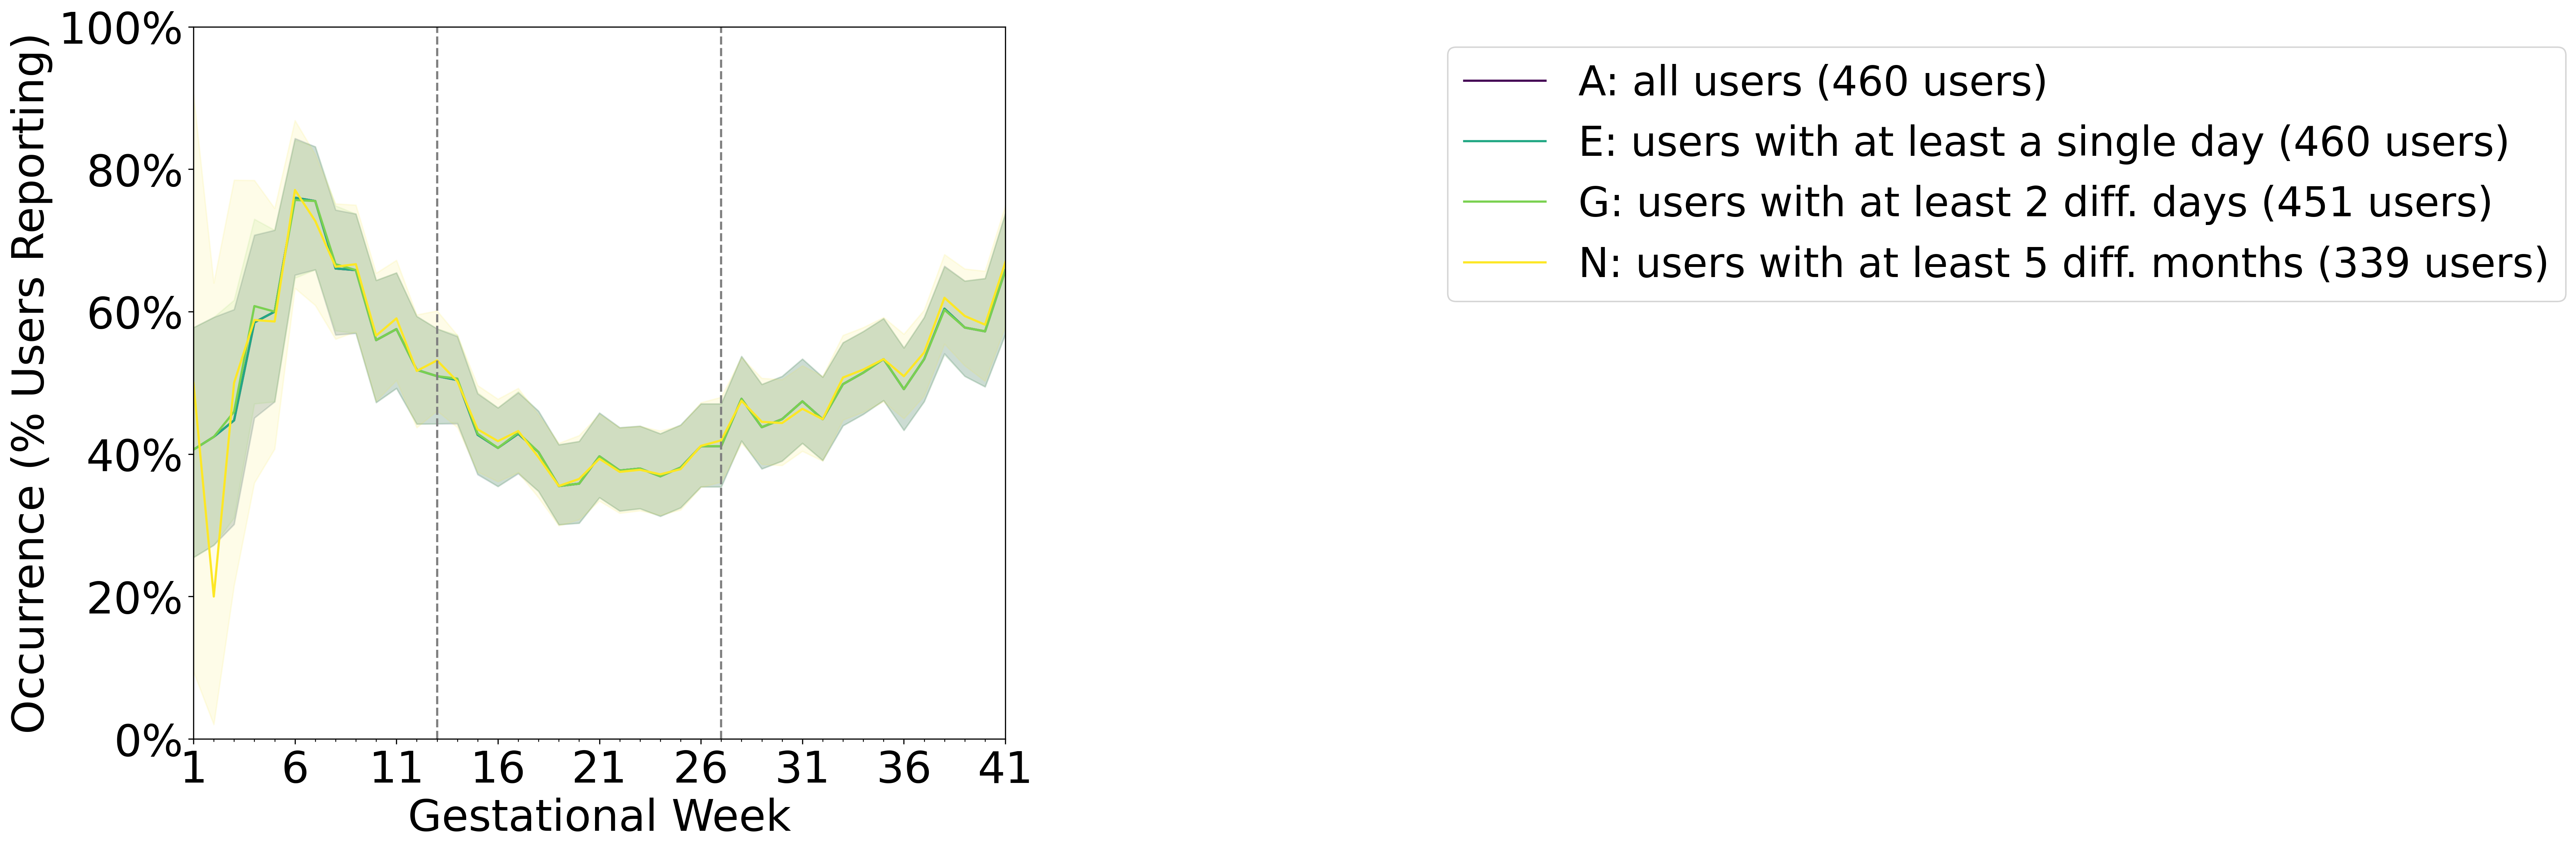

In [14]:
import matplotlib.cm as cm

# Plotting the line chart
cmap = cm.get_cmap('viridis', 6)
colors = [cmap(i) for i in range(6)]

plt.figure(figsize=(10, 9), dpi=300)

plt.plot(all_users_weekly_fatigue['gest_week'], all_users_weekly_fatigue['occurrence'] * 100, color=colors[0], label=f"A: all users ({len(merged_df['user_id'].unique())} users)")
plt.plot(min_1_dates_weekly_fatigue['gest_week'], min_1_dates_weekly_fatigue['occurrence'] * 100, color=colors[3], label=f"E: users with at least a single day ({len(merged_df_min_1_dates['user_id'].unique())} users)")
plt.plot(min_2_dates_weekly_fatigue['gest_week'], min_2_dates_weekly_fatigue['occurrence'] * 100, color=colors[4], label=f"G: users with at least 2 diff. days ({len(merged_df_min_2_dates['user_id'].unique())} users)")
plt.plot(min_5_months_weekly_fatigue['gest_week'], min_5_months_weekly_fatigue['occurrence'] * 100, color=colors[5], label=f"N: users with at least 5 diff. months ({len(merged_df_min_5_months['user_id'].unique())} users)")

plt.fill_between(all_users_weekly_fatigue['gest_week'], all_users_lower_bounds * 100, all_users_upper_bounds * 100, color=colors[0], alpha=0.1)
plt.fill_between(min_1_dates_weekly_fatigue['gest_week'], min_1_dates_lower_bounds * 100, min_1_dates_upper_bounds * 100, color=colors[3], alpha=0.1)
plt.fill_between(min_2_dates_weekly_fatigue['gest_week'], min_2_dates_lower_bounds * 100, min_2_dates_upper_bounds * 100, color=colors[4], alpha=0.1)
plt.fill_between(min_5_months_weekly_fatigue['gest_week'], min_5_months_lower_bounds * 100, min_5_months_upper_bounds * 100, color=colors[5], alpha=0.1)

# plt.title("Occurrence of Self-reported Fatigue Symptoms by Gestational Week")
plt.xlabel("Gestational Week", fontsize=30)
plt.ylabel("Occurrence (% Users Reporting)", fontsize=30)
# Adjusting x-axis ticks
plt.xticks(np.arange(1, 42, 5), fontsize=30)  # Major ticks
plt.yticks(fontsize=30)  # Increase y-tick font size
ax = plt.gca()  # Get the current axis
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))  # Minor ticks every 1 unit
# Adding percent sign to y-axis ticks
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}%'))

# plt.xticks(np.arange(1, 42, 5), minor=True)
plt.xlim(1, 41)
plt.ylim(0, 100)
plt.grid(False)
plt.axvline(13, color='grey', linestyle='--')
plt.axvline(27, color='grey', linestyle='--')
plt.legend(bbox_to_anchor=(1.52, 1), fontsize=28)
plt.show()


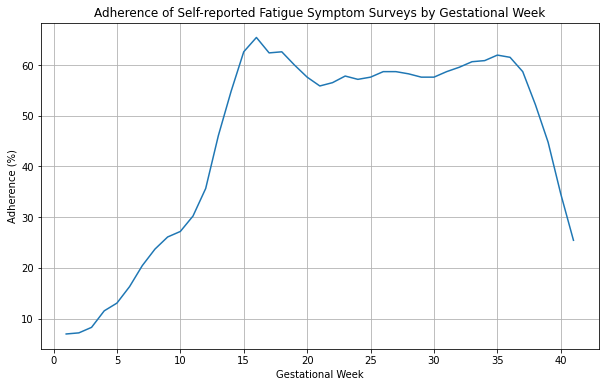

In [15]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(all_users_weekly_fatigue['gest_week'], all_users_weekly_fatigue['user_id_count_all'] / len(merged_df.user_id.unique()) * 100)
plt.title('Adherence of Self-reported Fatigue Symptom Surveys by Gestational Week')
plt.xlabel('Gestational Week')
plt.ylabel('Adherence (%)')
plt.grid(True)
plt.show()

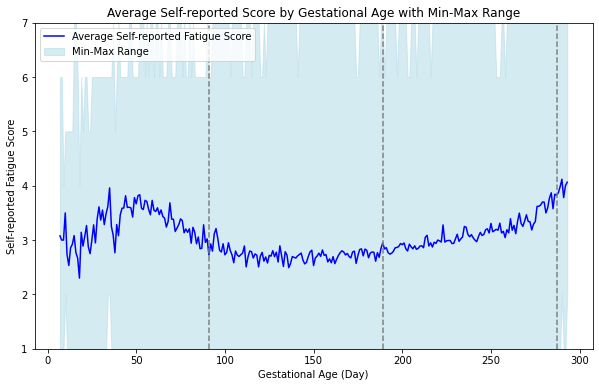

In [16]:
# Calculate the average, min, and max fas_score for each gest_age
grouped = merged_df.groupby('gest_age')['answer_text'].agg(['mean', 'min', 'max']).reset_index()
# grouped = merged_df.groupby('gest_age')['answer_text'].agg(
#     mean='mean', 
#     p95_lower=lambda x: np.percentile(x, 2.5), 
#     p95_upper=lambda x: np.percentile(x, 97.5)
# ).reset_index()
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['gest_age'], grouped['mean'], label='Average Self-reported Fatigue Score', color='blue')
plt.fill_between(grouped['gest_age'], grouped['min'], grouped['max'], color='lightblue', alpha=0.5, label='Min-Max Range')
# plt.fill_between(grouped['gest_age'], grouped['p95_lower'], grouped['p95_upper'], color='lightblue', alpha=0.5, label='95% Percentile Range')
plt.xlabel('Gestational Age (Day)')
plt.ylabel('Self-reported Fatigue Score')
plt.ylim(1, 7)
plt.title('Average Self-reported Score by Gestational Age with Min-Max Range')
plt.legend()
plt.grid(False)
plt.axvline(13*7, color='grey', linestyle='--')
plt.axvline(27*7, color='grey', linestyle='--')
plt.axvline(41*7, color='grey', linestyle='--')
plt.show()

In [17]:
df_temp = merged_df[['answer_text', 'user_id', 'gest_week']]
df_temp['gest_week'] = df_temp['gest_week'].astype('Int64')

mask = df_temp.groupby(['user_id', 'gest_week']).filter(lambda x: len(x) >= 2)
weekly_avg_df = mask.groupby(['user_id', 'gest_week']).agg({'answer_text': 'mean'}).reset_index()

import plotly.graph_objects as go
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.signal import find_peaks

# Rank ordering of participants


# Generate a reference U-shape curve (mean across all individuals)
def generate_reference_curve(data):
    ref_curve = data.groupby('gest_week')['answer_text'].mean()
    return ref_curve

def quadratic(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

r2 = []

# Count rejected participants:
lengthR = 0
vertexR = 0
min_time = 1
max_time = 40

for user in weekly_avg_df.user_id.unique():
    dfUser = weekly_avg_df[(weekly_avg_df['user_id'] == user)]
    dfUser = dfUser.sort_values('gest_week')
    dfUser = dfUser[dfUser['gest_week'] <= max_time]
    dfUser = dfUser[dfUser['gest_week'] >= min_time]


    if len(dfUser) < 15:
        lengthR += 1
        continue
    x_values = np.array(dfUser.gest_week.values, dtype=float)

    y_values_raw = np.array(dfUser.answer_text.values, dtype=float)

    mask = ~np.isnan(y_values_raw) & ~np.isinf(y_values_raw)
    x_values = x_values[mask]
    y_values_raw = y_values_raw[mask]

    if len(x_values) > 2 and len(y_values_raw) > 2:
        # Fit a quadratic function to the data
        params, _ = curve_fit(quadratic, x_values, y_values_raw)

        a, b, c = params
        vertex_x = -b/(2*a)
        vertex_y = quadratic(vertex_x, a, b, c)

        if (vertex_x < min_time or vertex_x > max_time):
            vertexR += 1
            continue

        y_fitted = quadratic(x_values, *params)

        r2_value = r2_score(y_values_raw, y_fitted)

        r2.append([r2_value, user])
    else:
        lengthR += 1

print('Rejected Length - ' + str(lengthR))
print('Rejected Vertex - ' + str(vertexR))
print('Total Participants - ' + str(len(r2)))

sorted_r2 = sorted(r2, key=lambda x: x[0], reverse=True)
sorted_r2_df = pd.DataFrame(sorted_r2, columns=['r2_value', 'user_id'])

# For Graphing Individual Curves 

# Generate a reference U-shape curve (mean across all individuals)
def generate_reference_curve(data):
    ref_curve = data.groupby('gest_week')['answer_text'].mean()
    return ref_curve

def quadratic(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

def fill_with_nans(x_values, y_values_raw, max_index):
    # Initialize an array with NaN values
    y_values_with_nans = np.full(max_index + 1, np.nan)
    
    # Fill in the values at the specified indices
    for i, x in enumerate(x_values):
        y_values_with_nans[int(x)-1] = y_values_raw[i]
    
    return y_values_with_nans

def closest_element(arr, target):
    closest = None
    for num in arr:
        if num >= target:
            if closest is None or num < closest:
                closest = num
    return closest
def count_greater_than(arr, threshold):
    count = 0
    for num in arr:
        if num > threshold:
            count += 1
        if count >= 2:
            return True
    return False
vertexs = []
r2_value_all = []
peaks_all = []
count = 0
all_data = []
stretch_data = []

for user in weekly_avg_df.user_id.unique():
# for user in [28]:
    dfUser = weekly_avg_df[(weekly_avg_df['user_id'] == user)]
    dfUser = dfUser.sort_values('gest_week')

    dfUser = dfUser[dfUser['gest_week'] <= max_time]
    dfUser = dfUser[dfUser['gest_week'] >= min_time]
    x_values = np.array(dfUser.gest_week.values, dtype=float)
    if len(x_values) > 2:
        y_values_raw = np.array(dfUser.answer_text.values, dtype=float)

        mask = ~np.isnan(y_values_raw) & ~np.isinf(y_values_raw)
        x_values = x_values[mask]
        y_values_raw = y_values_raw[mask]

        if len(x_values) > 2 and len(y_values_raw) > 2:
            # Fit a quadratic function to the data
            peaks, _ = find_peaks(y_values_raw)
            peaks_all.extend(peaks)
            # print("peaks: ", x_values[peaks])
            params, _ = curve_fit(quadratic, x_values, y_values_raw)

            # Extract parameters
            a, b, c = params
            vertex_x = -b/(2*a)
            vertex_y = quadratic(vertex_x, a, b, c)

            y_fitted = quadratic(x_values, *params)
            # if count_greater_than(x_values, 28):
            #     min_max_range = (y_fitted[-1] - y_fitted[np.where(x_values == closest_element(x_values, 28))]) / (x_values[-1] - x_values[np.where(x_values == closest_element(x_values, 28))])
            # stretch_data.append(min_max_range[0])
            stretch_data.append(a * 1000)
            
            r2_value = r2_score(y_values_raw, y_fitted)
            r2_value_all.append(r2_value)
            
            
            # if r2_value > 0.84:
            count += 1

            vertexs.append(vertex_x)
            new_y_values_raw = fill_with_nans(x_values, y_values_raw, max_time-1)
            all_data.append(new_y_values_raw)
            
#             # Graph the data along with the vertex
#             fig = go.Figure()
#             fig.add_trace(go.Scatter(x=x_values, y=y_values_raw, mode='markers', name='Raw Data'))
#             fig.add_trace(go.Scatter(x=x_values, y=y_fitted, mode='lines', name='Quadratic Fit'))
#             fig.add_trace(go.Scatter(x=[vertex_x], y=[vertex_y], mode='markers', marker=dict(color='red', size=10), name='Vertex'))

#             # fig.update_xaxes(range=[-150, 0])
#             fig.update_xaxes(range=[min_time, max_time])
#             fig.update_yaxes(range=[1, 7])  
#             fig.update_layout(title='Quadratic fit with Vertex on Weekly Data - ' + f'user: {user}, R2 Score={r2_value:.2f}', xaxis_title='Gestational Week', yaxis_title='Daily Fatigue Symptom', legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01), width=700, height=400)
#             fig.show()
            
print(count)

/tmp/ipykernel_3855/303047642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['gest_week'] = df_temp['gest_week'].astype('Int64')


Rejected Length - 221
Rejected Vertex - 25
Total Participants - 189


/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of

377


In [18]:
hrv_inflection_reads = pd.read_csv("hrv_best_fits.csv")
sleep_slope_reads = pd.read_csv("sleep_slope.csv")

In [19]:
sleep_slope_reads[sleep_slope_reads['Feature'] == 'Deep Sleep Slope']

,Feature,Value
0,Deep Sleep Slope,-0.005644
1,Deep Sleep Slope,-0.023778
2,Deep Sleep Slope,-0.015153
3,Deep Sleep Slope,-0.021948
4,Deep Sleep Slope,-0.026163
...,...,...
380,Deep Sleep Slope,-0.020099
381,Deep Sleep Slope,-0.010020
382,Deep Sleep Slope,-0.002859
383,Deep Sleep Slope,-0.016527


In [20]:
# violin plot
# len(vertexs)
data = [num for num in vertexs if not (num > max_time or num < min_time)]
data2 = [num for num in peaks_all if not (num > max_time or num < min_time)]
data3 = [num for num in hrv_inflection_reads['vertex'].tolist() if not (num > max_time or num < min_time)]
data4 = sleep_slope_reads[sleep_slope_reads['Feature'] == 'Deep Sleep Slope']['Value'].tolist()
data5 = sleep_slope_reads[sleep_slope_reads['Feature'] == 'Awake Time Slope']['Value'].tolist()
# # data3 = [num for num in stretch_data if not (num > max_time or num < min_time)]


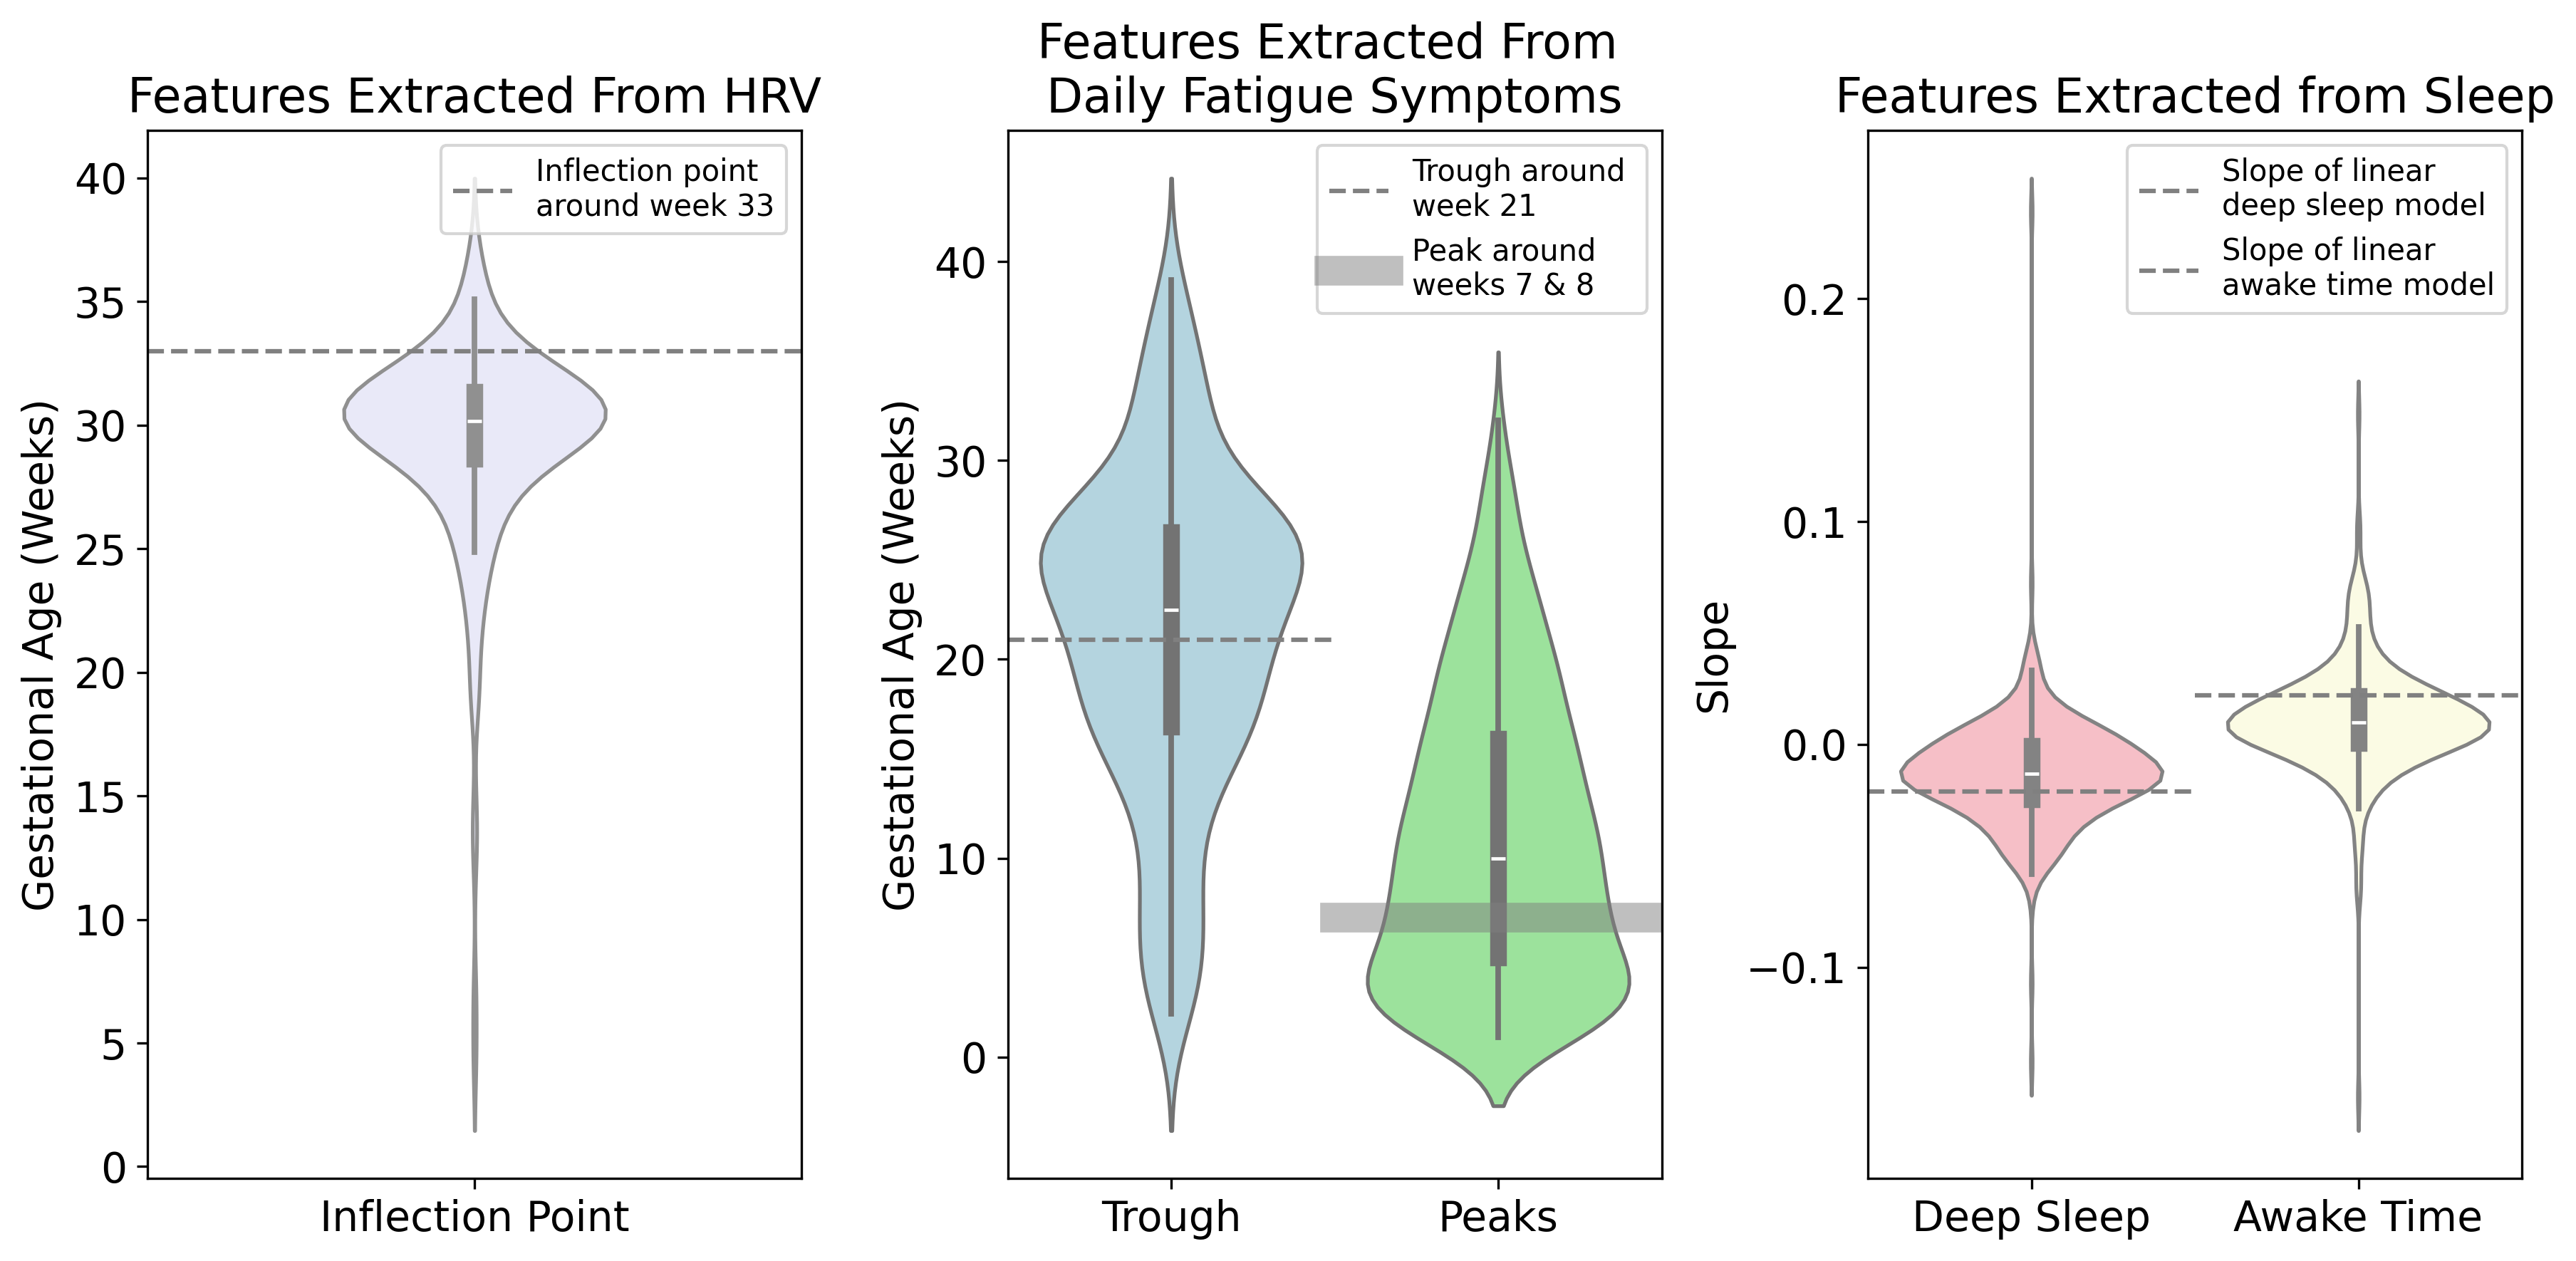

In [21]:
# Create figure with the same size but adjusting the middle panel to be half width
plt.figure(figsize=(12, 6), dpi=300)

# Panel 1 HRV
plt.subplot(1, 3, 1)
sns.violinplot(data=[data3], inner='box', palette=['#E6E6FA'], width=0.4)  # Reduced violin plot width
plt.title('Features Extracted From HRV', fontsize=16)
plt.ylabel('Gestational Age (Weeks)', fontsize=14)
plt.xticks([0], ['Inflection Point'], fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(33, xmin=0, xmax=1, color='grey', linestyle='--', label='Inflection point \naround week 33')
plt.legend()

# Panel 2 Fatigue
plt.subplot(1, 3, 2)
sns.violinplot(data=[data, data2], inner='box', palette=['lightblue', 'lightgreen'])
plt.title('Features Extracted From \nDaily Fatigue Symptoms', fontsize=16)
plt.ylabel('Gestational Age (Weeks)', fontsize=14)
plt.xticks([0, 1], ['Trough', 'Peaks'], fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(21, xmin=0, xmax=0.5, color='grey', linestyle='--', label='Trough around \nweek 21')
plt.axhline(7, xmin=0.5, xmax=1, color='grey', linestyle='-', alpha=0.5, linewidth=10, label='Peak around \nweeks 7 & 8')
plt.legend()

# Panel 3
plt.subplot(1, 3, 3)
sns.violinplot(data=[data4, data5], inner='box', palette=['lightpink', 'lightyellow'])
plt.title('Features Extracted from Sleep', fontsize=16)
plt.ylabel('Slope', fontsize=14)
plt.xticks([0, 1], ['Deep Sleep', 'Awake Time'], fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(-0.021, xmin=0, xmax=0.5, color='grey', linestyle='--', label='Slope of linear \ndeep sleep model')
plt.axhline(0.022000000000000002, xmin=0.5, xmax=1, color='grey', linestyle='--', label='Slope of linear \nawake time model')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
def percentage_rounded_to(numbers, target, target_type="discrete"):
    if target_type == "discrete":
        rounded_counts = sum(1 for num in numbers if round(num) in target)
        percentage = (rounded_counts / len(numbers)) * 100 if numbers else 0
    elif target_type == "continuous":
        rounded_counts = sum(1 for num in numbers if round(num, 2) == round(target, 2))
        percentage = (rounded_counts / len(numbers)) * 100 if numbers else 0
    return percentage

# Example usage
hrv_percent_in_target = percentage_rounded_to(data3, {33})
fatigue_trough_percent_in_target = percentage_rounded_to(data, {21})
fatigue_peak_percent_in_target = percentage_rounded_to(data2, {7, 8})
sleep_slope_peak_percent_in_target = percentage_rounded_to(data4, -0.021, target_type="continuous")
awake_slope_peak_percent_in_target = percentage_rounded_to(data5, 0.022000000000000002, target_type="continuous")

print(f"Percentage of HRV Inflection Point rounding to Gestational Age Week 33: {hrv_percent_in_target:.2f}%")
print(f"Percentage of Fatigue Trough rounding to week 21: {fatigue_trough_percent_in_target:.2f}%")
print(f"Percentage of Fatigue Peak rounding to week 7 & 8: {fatigue_peak_percent_in_target:.2f}%")
print(f"Percentage of Sleep Slope rounding to -0.02: {sleep_slope_peak_percent_in_target:.2f}%")
print(f"Percentage of Awake Slope rounding to 0.02: {awake_slope_peak_percent_in_target:.2f}%")

Percentage of HRV Inflection Point rounding to Gestational Age Week 33: 4.76%
Percentage of Fatigue Trough rounding to week 21: 5.64%
Percentage of Fatigue Peak rounding to week 7 & 8: 9.69%
Percentage of Sleep Slope rounding to -0.02: 21.82%
Percentage of Awake Slope rounding to 0.02: 17.92%


In [33]:
import statistics

def variance_and_cv(numbers):
    if len(numbers) < 2:
        return "Variance and CV require at least two data points."
    
    variance = statistics.variance(numbers)  # Sample variance
    mean = statistics.mean(numbers)  # Mean
    std_dev = variance ** 0.5  # Standard deviation

    cv = (std_dev / mean) * 100 if mean != 0 else float('inf')  # CV as a percentage

    return variance, cv

hrv_variance, hrv_cv = variance_and_cv(data3)
fatigue_trough_variance, fatigue_trough_cv = variance_and_cv(data)
fatigue_peak_variance, fatigue_peak_cv = variance_and_cv(data2)
sleep_slope_variance, sleep_slope_cv = variance_and_cv(data4)
awake_slope_variance, awake_slope_cv = variance_and_cv(data5)

print(f"HRV Inflection Point --- Variance: {hrv_variance:.4f}, Coefficient of Variation (CV): {hrv_cv:.2f}%")
print(f"Fatigue Trough --------- Variance: {fatigue_trough_variance:.4f}, Coefficient of Variation (CV): {fatigue_trough_cv:.2f}%")
print(f"Fatigue Peak ----------- Variance: {fatigue_peak_variance:.4f}, Coefficient of Variation (CV): {fatigue_peak_cv:.2f}%")
print(f"Sleep Slope ------------ Variance: {sleep_slope_variance:.4f}, Coefficient of Variation (CV): {sleep_slope_cv:.2f}%")
print(f"Awake Slope ------------ Variance: {awake_slope_variance:.4f}, Coefficient of Variation (CV): {awake_slope_cv:.2f}%")


HRV Inflection Point --- Variance: 17.5407, Coefficient of Variation (CV): 14.24%
Fatigue Trough --------- Variance: 67.0985, Coefficient of Variation (CV): 38.37%
Fatigue Peak ----------- Variance: 55.0000, Coefficient of Variation (CV): 67.42%
Sleep Slope ------------ Variance: 0.0006, Coefficient of Variation (CV): -192.40%
Awake Slope ------------ Variance: 0.0006, Coefficient of Variation (CV): 211.81%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


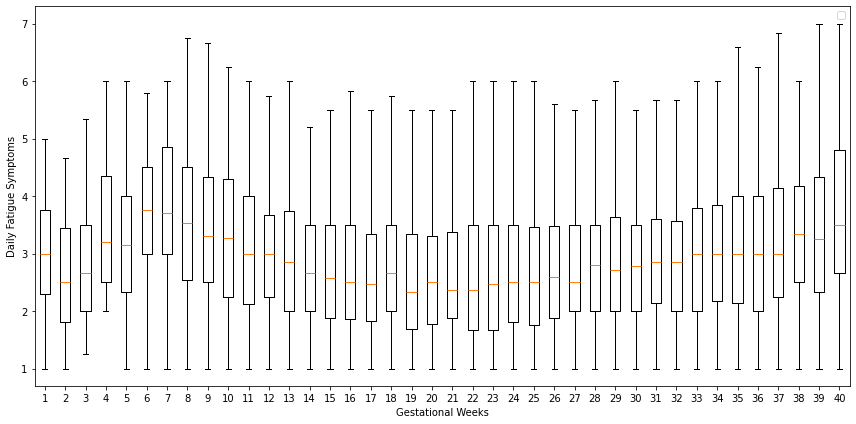

In [28]:
all_data = np.array(all_data).T
nan_counts = np.sum(~np.isnan(all_data), axis=1)

# Create the figure and first axis for the box plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Box plot on the primary axis
ax1.boxplot([row[~np.isnan(row)] for row in all_data], showfliers=False)
ax1.set_xlabel('Gestational Weeks')
ax1.set_ylabel('Daily Fatigue Symptoms')

# Create a second axis sharing the same x-axis for the NaN counts
# ax2 = ax1.twinx()
# ax2.plot(range(1, len(nan_counts) + 1), nan_counts, color='red', marker='o', label='Sample Counts', alpha=0.4)
# ax2.set_ylabel('Sample Counts', color='red')

# Set the title and show the plot
# plt.title('Box Plot For Daily Fatigue Symptoms With Sample Counts')
plt.legend()
fig.tight_layout()
plt.show()


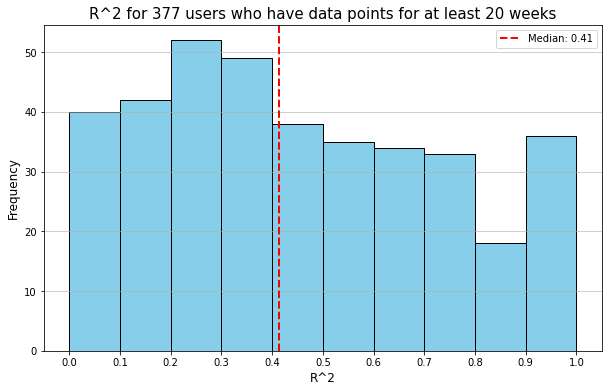

In [29]:
# Setting the number of bins for better visualization
num_bins = 10

# Creating the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better appearance
hist, bins, _ = plt.hist(r2_value_all, bins=num_bins, edgecolor='black', color='skyblue', align='mid', range=(0,1))

# Adding the median line
median_value = np.median(r2_value_all)
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Adding titles and labels
plt.title(f'R^2 for {len(r2_value_all)} users who have data points for at least 20 weeks', fontsize=15)
plt.xlabel('R^2', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Setting x-ticks to align with the bins
plt.xticks(bins.round(2))

# Displaying the plot
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

## FAS survey

In [30]:
# A description of the fatigue experienced is presented for the total score where:

# - less than 22 indicates “normal” (i.e. healthy) levels of fatigue
# - between 22 and 34 indicates mild-to-moderate fatigue
# - 35 or more indicates severe fatigue (Hendricks et al., 2018)
def map_answer_to_int(row):
    curr_level_mapping = question_level_mapping_dict[row['question_id']]
    return curr_level_mapping[row['answer_text']]

identifier = 'user_id'
question_148_level = {"Yes": 0, "No": 0}
question_149_to_157_level = {"Never": 1, 'Sometimes': 2, 'Regularly': 3, 'Often': 4, 'Always': 5}
question_158_level = {"Never": 5, 'Sometimes': 4, 'Regularly': 3, 'Often': 2, 'Always': 1}
disabled_level = {"Never": 0, 'Sometimes': 0, 'Regularly': 0, 'Often': 0, 'Always': 0}

# for FAS, A total FAS score < 22 indicates no fatigue, a score ≥ 22 indicates fatigue.
question_id_lst = list(range(148, 159))
num_questions = len(list(range(148, 159)))
question_levels_lst = [question_149_to_157_level] * num_questions
question_levels_lst[0] = question_148_level
question_levels_lst[4] = question_158_level
question_levels_lst[-1] = question_158_level
question_level_mapping_dict = dict(zip(question_id_lst, question_levels_lst))

weekly_feature_name = "fas_score"
df_weekly_fatigue = df_survey.loc[df_survey['title'] =='Fatigue survey']
df_weekly_fatigue = df_weekly_fatigue.drop_duplicates(subset=['user_id', 'event_date', 'question_id'])
df_weekly_fatigue = df_weekly_fatigue.dropna()
df_weekly_fatigue[weekly_feature_name] = df_weekly_fatigue.apply(map_answer_to_int, axis=1)
grouped_df_weekly_fatigue = df_weekly_fatigue.groupby([identifier, 'event_date'])[weekly_feature_name].sum().reset_index()
grouped_df_weekly_fatigue['event_date'] = pd.to_datetime(grouped_df_weekly_fatigue['event_date'])
grouped_df_weekly_fatigue['week_year'] = grouped_df_weekly_fatigue['event_date'].dt.strftime('%Y-%U')
grouped_df_weekly_fatigue["fatigue_boolean"] = grouped_df_weekly_fatigue['fas_score'].apply(lambda x: 1 if x >= 22 else 0)

merged_df = pd.merge(grouped_df_weekly_fatigue[['user_id', 'event_date', 'fatigue_boolean', 'fas_score']], df_birth[['user_id', 'birth_date', 'conception']], on='user_id', how='inner')
merged_df['conception'] = pd.to_datetime(merged_df['conception'])
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])
merged_df['gest_age'] = (merged_df['event_date'] - merged_df['conception']).dt.days
merged_df = merged_df.dropna()
merged_df['gest_week'] = merged_df['gest_age']//7
merged_df = merged_df[(merged_df['gest_week']>=1) & (merged_df['gest_week']<=41)]


NameError: name 'df_survey' is not defined

### A: All data

In [31]:
# Aggregate data by gestational week
all_users_has_fatigue = merged_df[merged_df['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
all_users = merged_df.groupby('gest_week')['user_id'].nunique().reset_index()
all_users_weekly_fatigue = all_users.merge(all_users_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
all_users_weekly_fatigue['occurrence'] = all_users_weekly_fatigue['user_id_count_positive'] / all_users_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
all_users_lower_bounds, all_users_upper_bounds = smp.proportion_confint(all_users_weekly_fatigue['user_id_count_positive'].tolist(), all_users_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')

### E: Only users tracking on a single day

In [21]:
# Group by user_id and count unique event_dates
user_event_counts = merged_df.groupby('user_id')['event_date'].nunique()

# Filter user_ids with at least two different event_dates
users_with_min_1_dates = user_event_counts[user_event_counts >= 1].index

# Extract rows with these user_ids
merged_df_min_1_dates = merged_df[merged_df['user_id'].isin(users_with_min_1_dates)]

In [22]:
# Aggregate data by gestational week
min_1_dates_has_fatigue = merged_df_min_1_dates[merged_df_min_1_dates['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_1_dates_users = merged_df_min_1_dates.groupby('gest_week')['user_id'].nunique().reset_index()
min_1_dates_weekly_fatigue = min_1_dates_users.merge(min_1_dates_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_1_dates_weekly_fatigue['occurrence'] = min_1_dates_weekly_fatigue['user_id_count_positive'] / min_1_dates_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_1_dates_lower_bounds, min_1_dates_upper_bounds = smp.proportion_confint(min_1_dates_weekly_fatigue['user_id_count_positive'].tolist(), min_1_dates_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


### G: Only users tracking symptoms on min. 2 diff. days

In [23]:
# Group by user_id and count unique event_dates
user_event_counts = merged_df.groupby('user_id')['event_date'].nunique()

# Filter user_ids with at least two different event_dates
users_with_min_2_dates = user_event_counts[user_event_counts >= 2].index

# Extract rows with these user_ids
merged_df_min_2_dates = merged_df[merged_df['user_id'].isin(users_with_min_2_dates)]

In [24]:
# Aggregate data by gestational week
min_2_dates_has_fatigue = merged_df_min_2_dates[merged_df_min_2_dates['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_2_dates_users = merged_df_min_2_dates.groupby('gest_week')['user_id'].nunique().reset_index()
min_2_dates_weekly_fatigue = min_2_dates_users.merge(min_2_dates_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_2_dates_weekly_fatigue['occurrence'] = min_2_dates_weekly_fatigue['user_id_count_positive'] / min_2_dates_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_2_dates_lower_bounds, min_2_dates_upper_bounds = smp.proportion_confint(min_2_dates_weekly_fatigue['user_id_count_positive'].tolist(), min_2_dates_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


### N: Only users tracking symptoms in min. 5 diff. months

In [25]:
# Extract year and month
merged_df['year_month'] = merged_df['event_date'].dt.to_period('M')

# Group by user_id and count unique year_month
user_month_counts = merged_df.groupby('user_id')['year_month'].nunique()

# Filter user_ids with at least 5 different months
users_with_min_5_months = user_month_counts[user_month_counts >= 5].index

# Extract rows with these user_ids
merged_df_min_5_months = merged_df[merged_df['user_id'].isin(users_with_min_5_months)]

In [26]:
# Aggregate data by gestational week
min_5_months_has_fatigue = merged_df_min_5_months[merged_df_min_5_months['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_5_months_users = merged_df_min_5_months.groupby('gest_week')['user_id'].nunique().reset_index()
min_5_months_weekly_fatigue = min_5_months_users.merge(min_5_months_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_5_months_weekly_fatigue['occurrence'] = min_5_months_weekly_fatigue['user_id_count_positive'] / min_5_months_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_5_months_lower_bounds, min_5_months_upper_bounds = smp.proportion_confint(min_5_months_weekly_fatigue['user_id_count_positive'].tolist(), min_5_months_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


In [28]:
print(f"A - total occurance: {all_users_weekly_fatigue['user_id_count_positive'].sum() / all_users_weekly_fatigue['user_id_count_all'].sum() * 100}")
print(f"E - total occurance: {min_1_dates_weekly_fatigue['user_id_count_positive'].sum() / min_1_dates_weekly_fatigue['user_id_count_all'].sum() * 100}")
print(f"G - total occurance: {min_2_dates_weekly_fatigue['user_id_count_positive'].sum() / min_2_dates_weekly_fatigue['user_id_count_all'].sum() * 100}")
print(f"N - total occurance: {min_5_months_weekly_fatigue['user_id_count_positive'].sum() / min_5_months_weekly_fatigue['user_id_count_all'].sum() * 100}")


A - total occurance: 56.734461669748256
E - total occurance: 56.734461669748256
G - total occurance: 56.70940170940171
N - total occurance: 56.53095202058422


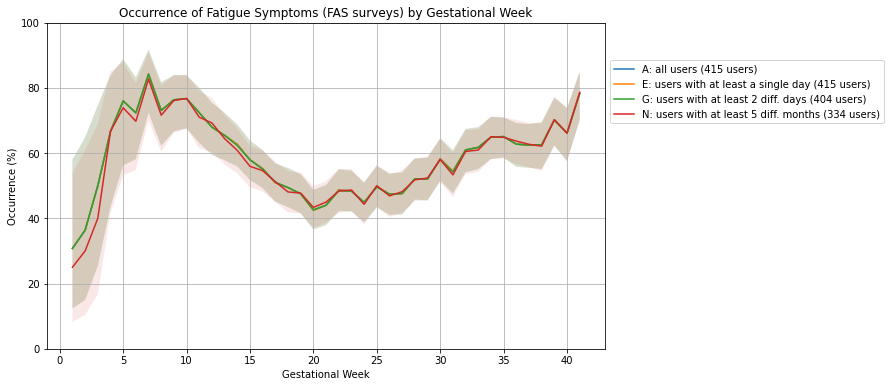

In [27]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(all_users_weekly_fatigue['gest_week'], all_users_weekly_fatigue['occurrence'] * 100, label=f"A: all users ({len(merged_df['user_id'].unique())} users)")
plt.plot(min_1_dates_weekly_fatigue['gest_week'], min_1_dates_weekly_fatigue['occurrence'] * 100, label=f"E: users with at least a single day ({len(merged_df_min_1_dates['user_id'].unique())} users)")
plt.plot(min_2_dates_weekly_fatigue['gest_week'], min_2_dates_weekly_fatigue['occurrence'] * 100, label=f"G: users with at least 2 diff. days ({len(merged_df_min_2_dates['user_id'].unique())} users)")
plt.plot(min_5_months_weekly_fatigue['gest_week'], min_5_months_weekly_fatigue['occurrence'] * 100, label=f"N: users with at least 5 diff. months ({len(merged_df_min_5_months['user_id'].unique())} users)")

plt.fill_between(all_users_weekly_fatigue['gest_week'], all_users_lower_bounds * 100, all_users_upper_bounds * 100, alpha=0.1)
plt.fill_between(min_1_dates_weekly_fatigue['gest_week'], min_1_dates_lower_bounds * 100, min_1_dates_upper_bounds * 100, alpha=0.1)
plt.fill_between(min_2_dates_weekly_fatigue['gest_week'], min_2_dates_lower_bounds * 100, min_2_dates_upper_bounds * 100, alpha=0.1)
plt.fill_between(min_5_months_weekly_fatigue['gest_week'], min_5_months_lower_bounds * 100, min_5_months_upper_bounds * 100, alpha=0.1)

plt.title("Occurrence of Fatigue Symptoms (FAS surveys) by Gestational Week")
plt.xlabel("Gestational Week")
plt.ylabel("Occurrence (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 0.9))
plt.show()


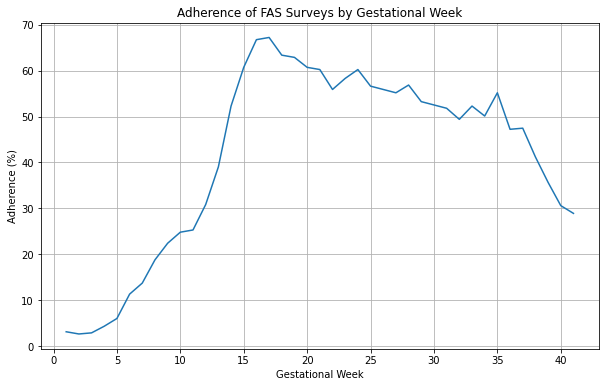

In [53]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(all_users_weekly_fatigue['gest_week'], all_users_weekly_fatigue['user_id_count_all'] / len(merged_df.user_id.unique()) * 100)
plt.title('Adherence of FAS Surveys by Gestational Week')
plt.xlabel('Gestational Week')
plt.ylabel('Adherence (%)')
plt.grid(True)
plt.show()

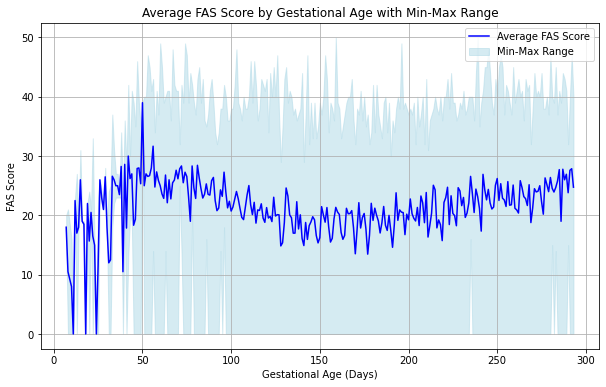

In [54]:
# Calculate the average, min, and max fas_score for each gest_age
grouped = merged_df.groupby('gest_age')['fas_score'].agg(['mean', 'min', 'max']).reset_index()
# grouped = merged_df.groupby('gest_age')['fas_score'].agg(
#     mean='mean', 
#     p95_lower=lambda x: np.percentile(x, 2.5), 
#     p95_upper=lambda x: np.percentile(x, 97.5)
# ).reset_index()
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['gest_age'], grouped['mean'], label='Average FAS Score', color='blue')
plt.fill_between(grouped['gest_age'], grouped['min'], grouped['max'], color='lightblue', alpha=0.5, label='Min-Max Range')
# plt.fill_between(grouped['gest_age'], grouped['p95_lower'], grouped['p95_upper'], color='lightblue', alpha=0.5, label='95% Percentile Range')
plt.xlabel('Gestational Age (Days)')
plt.ylabel('FAS Score')
# plt.ylim(1, 7)
plt.title('Average FAS Score by Gestational Age with Min-Max Range')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
weekly_avg_df = merged_df[['user_id', 'gest_week', 'fas_score']]
weekly_avg_df['gest_week'] = weekly_avg_df['gest_week'].astype('Int64')


import plotly.graph_objects as go
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Rank ordering of participants

# Generate a reference U-shape curve (mean across all individuals)
def generate_reference_curve(data):
    ref_curve = data.groupby('gest_week')['fas_score'].mean()
    return ref_curve

def quadratic(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

r2 = []

# Count rejected participants:
lengthR = 0
vertexR = 0

for user in weekly_avg_df.user_id.unique():
    dfUser = weekly_avg_df[(weekly_avg_df['user_id'] == user)]
    dfUser = dfUser.sort_values('gest_week')
    dfUser = dfUser[dfUser['gest_week'] <= 40]
    dfUser = dfUser[dfUser['gest_week'] >= 10]


    if len(dfUser) < 15:
        lengthR += 1
        continue
    x_values = np.array(dfUser.gest_week.values, dtype=float)

    y_values_raw = np.array(dfUser.fas_score.values, dtype=float)

    mask = ~np.isnan(y_values_raw) & ~np.isinf(y_values_raw)
    x_values = x_values[mask]
    y_values_raw = y_values_raw[mask]

    if len(x_values) > 2 and len(y_values_raw) > 2:
        # Fit a quadratic function to the data
        params, _ = curve_fit(quadratic, x_values, y_values_raw)

        a, b, c = params
        vertex_x = -b/(2*a)
        vertex_y = quadratic(vertex_x, a, b, c)

        if (vertex_x < 10 or vertex_x > 40):
            vertexR += 1
            continue

        y_fitted = quadratic(x_values, *params)

        r2_value = r2_score(y_values_raw, y_fitted)

        r2.append([r2_value, user])
    else:
        lengthR += 1

print('Rejected Length - ' + str(lengthR))
print('Rejected Vertex - ' + str(vertexR))
print('Total Participants - ' + str(len(r2)))

sorted_r2 = sorted(r2, key=lambda x: x[0], reverse=True)
sorted_r2_df = pd.DataFrame(sorted_r2, columns=['r2_value', 'user_id'])

# For Graphing Individual Curves 

# Generate a reference U-shape curve (mean across all individuals)
def generate_reference_curve(data):
    ref_curve = data.groupby('gest_week')['fas_score'].mean()
    return ref_curve

def quadratic(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

vertexs = []

for user in weekly_avg_df.user_id.unique():
    dfUser = weekly_avg_df[(weekly_avg_df['user_id'] == user)]
    dfUser = dfUser.sort_values('gest_week')

    dfUser = dfUser[dfUser['gest_week'] <= 40]
    dfUser = dfUser[dfUser['gest_week'] >= 10]
    x_values = np.array(dfUser.gest_week.values, dtype=float)
    y_values_raw = np.array(dfUser.fas_score.values, dtype=float)

    mask = ~np.isnan(y_values_raw) & ~np.isinf(y_values_raw)
    x_values = x_values[mask]
    y_values_raw = y_values_raw[mask]

    if len(x_values) > 2 and len(y_values_raw) > 2:
        # Fit a quadratic function to the data
        params, _ = curve_fit(quadratic, x_values, y_values_raw)

        # Extract parameters
        a, b, c = params
        vertex_x = -b/(2*a)
        vertex_y = quadratic(vertex_x, a, b, c)

        y_fitted = quadratic(x_values, *params)

        r2_value = r2_score(y_values_raw, y_fitted)

        vertexs.append(vertex_x)
        # Graph the data along with the vertex
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x_values, y=y_values_raw, mode='markers', name='Raw Data'))
        fig.add_trace(go.Scatter(x=x_values, y=y_fitted, mode='lines', name='Quadratic Fit'))
        fig.add_trace(go.Scatter(x=[vertex_x], y=[vertex_y], mode='markers', marker=dict(color='red', size=10), name='Vertex'))

        # fig.update_xaxes(range=[-150, 0])
        fig.update_xaxes(range=[10, 40])
        fig.update_layout(title='Quadratic fit with Vertex on Weekly Data - ' + f'user: {user}, R2 Score={r2_value:.2f}', xaxis_title='Gestational Week', yaxis_title='Daily Fatigue Symptom', legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
        fig.show()
print(np.mean(vertexs))

KeyError: "['fas_score'] not in index"

## Robin's method

## Tina's method

In [ ]:
model_formula = 'smoothed_deep ~ age + bmi + time + GW_class:bmi_c + bmi_c:age_c + GW_class:age_c'

# Fit the mixed effects linear model
mixedlm_model = smf.mixedlm(model_formula, df_w_static, groups=df_w_static['map_id'])#, re_formula="~time")
mixedlm_result = mixedlm_model.fit()

# Print the results
print(mixedlm_result.summary())
#"""
var_components = mixedlm_result.cov_re.iloc[0, 0]  # Random effects variance (tau^2)
residual_variance = mixedlm_result.scale            # Residual variance (sigma^2)

# Calculate ICC
icc = var_components / (var_components + residual_variance)

print(f"Interclass Correlation Coefficient (ICC): {icc:.3f}")

# Interpretation
if icc < 0.1:
    print("Little, if any, group variability.")
elif icc < 0.5:
    print("Moderate group variability.")
else:
    print("Substantial group variability.")


In [ ]:
# You need to change smoothed_deep to fatigue and change the variables that you want to see the effect on prediction
# The time shows the gestational week point the number of days (for this method you don't need to impute the missing data)


df_w_static['PredictedDeepSleep'] = mixedlm_result.predict(df_w_static)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of actual deep sleep times
sns.scatterplot(x='time', y='smoothed_deep', data=df_w_static, color='blue', alpha=0.5, label='Actual Deep Sleep')

# Line plot of predicted deep sleep times
sns.lineplot(x='time', y='PredictedDeepSleep', data=df_w_static, color='red', label='Predicted Deep Sleep', errorbar=None)

plt.xlabel('Gestational Week')
plt.ylabel('Deep Sleep (hours)')
plt.title('Weekly Changes in Deep Sleep Across Gestational Weeks')
plt.legend()

plt.show()